In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

In [2]:
# Load data
data = pd.read_csv('data.csv', delimiter=';')
#drop column mcap_l 
data = data.drop(columns=['mcap_l'])
#drop nan in Rn column
data = data.dropna(subset=['Rn'])
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# Sort the data by permno and date
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
display(data.isna().sum())
data

permno       0
date         0
Rn           0
shrout       0
prc          0
mcap         0
rf        2076
Rm           0
const        0
Rn_e      2076
Rm_e      2076
dtype: int64

,permno,date,Rn,shrout,prc,mcap,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-01,0.162621,4361.0,10.3000,44918.3000,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-01,-0.018932,4361.0,10.0600,43871.6600,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-01,-0.000656,4361.0,10.0084,43646.6324,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-01,0.020643,4361.0,10.1700,44351.3700,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-01,0.124385,6070.0,11.3900,69137.3000,0.000118,0.020036,1,0.124267,0.019918
...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.0200,453167.6200,0.004463,-0.020605,1,-0.041619,-0.025068
1432774,93426,2023-09-01,-0.067740,12581.0,33.5800,422469.9800,0.004472,-0.047390,1,-0.072212,-0.051862
1432775,93426,2023-10-01,-0.108993,12581.0,29.9200,376423.5200,0.004475,-0.028867,1,-0.113468,-0.033342
1432776,93426,2023-11-01,0.019051,12510.0,30.4900,381429.9000,0.004455,0.092057,1,0.014596,0.087602


In [3]:
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

In [4]:
# shift the LN_Cret12 column by 1
data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
data.dropna(subset=['LN_Cret12'], inplace=True)


In [5]:
q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
data

,permno,date,Rn,shrout,prc,mcap,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Momentum
12,10001,2010-12-01,0.052291,7834.0,10.52,82413.68,0.000068,0.067182,1,0.052223,0.067114,0.297149,7
13,10001,2011-01-01,0.028992,7834.0,10.78,84450.52,0.000125,0.019183,1,0.028867,0.019058,0.020414,3
14,10001,2011-02-01,0.022727,7834.0,10.98,86017.32,0.000065,0.038156,1,0.022662,0.038091,0.090498,2
15,10001,2011-03-01,0.072404,7834.0,11.73,91892.82,0.000049,0.003341,1,0.072355,0.003292,0.119734,3
16,10001,2011-04-01,-0.038789,8151.0,11.23,91535.73,0.000013,0.028597,1,-0.038802,0.028584,0.121773,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,0.004463,-0.020605,1,-0.041619,-0.025068,0.175187,7
1432774,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,0.004472,-0.047390,1,-0.072212,-0.051862,0.086501,5
1432775,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,0.004475,-0.028867,1,-0.113468,-0.033342,0.196638,5
1432776,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,0.004455,0.092057,1,0.014596,0.087602,-0.005050,5


In [6]:
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. VW Portfolios
data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()

In [10]:
ret_ew

,date,Momentum,Rn,excess
0,1965-01-01,0,0.134327,0.131090
1,1965-01-01,1,0.074002,0.070765
2,1965-01-01,2,0.068610,0.065373
3,1965-01-01,3,0.050721,0.047485
4,1965-01-01,4,0.054935,0.051698
...,...,...,...,...
7075,2023-12-01,5,0.072178,0.067694
7076,2023-12-01,6,0.073017,0.068533
7077,2023-12-01,7,0.055509,0.051025
7078,2023-12-01,8,0.074744,0.070260


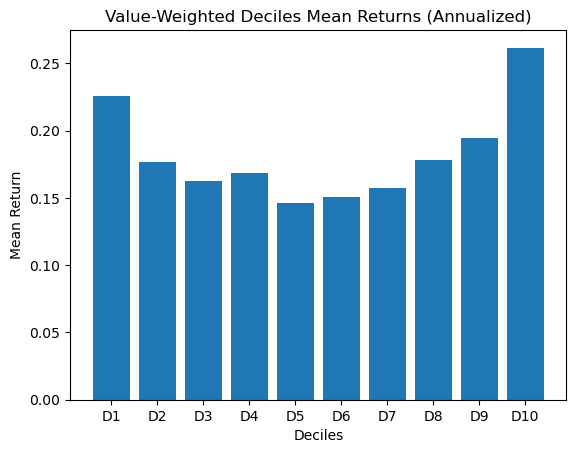

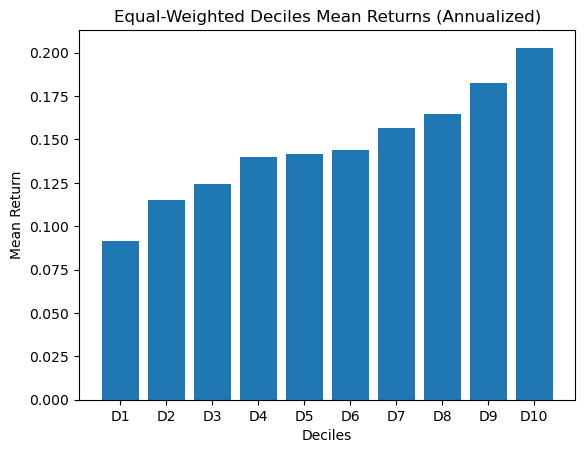

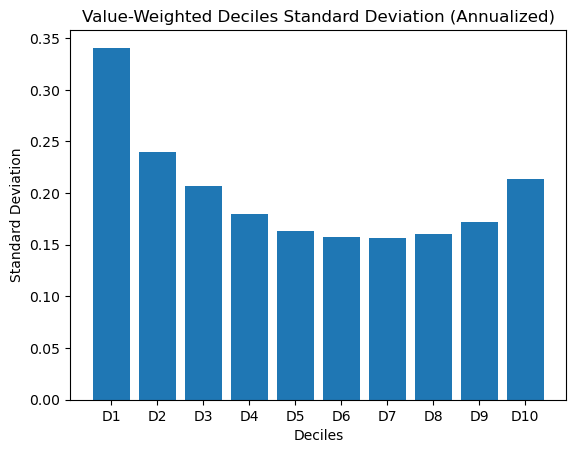

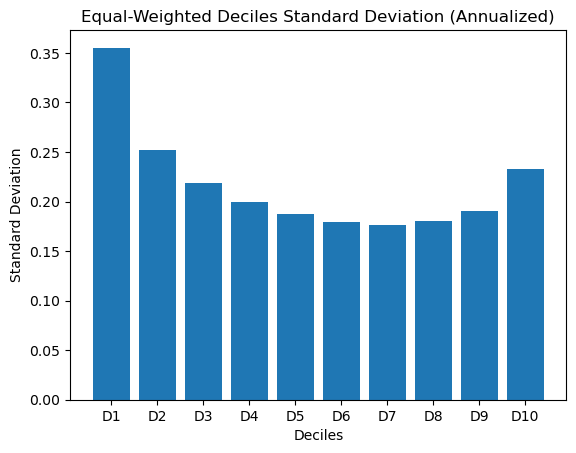

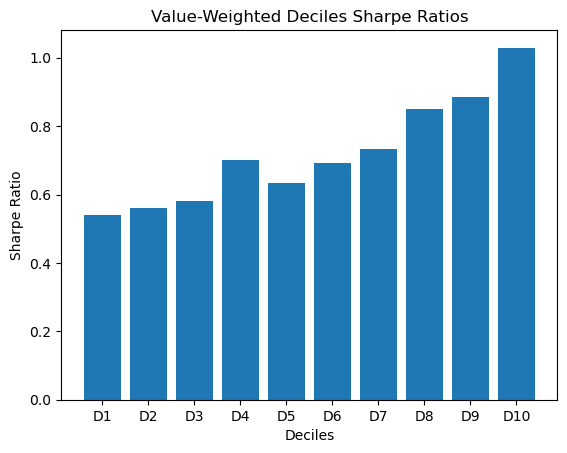

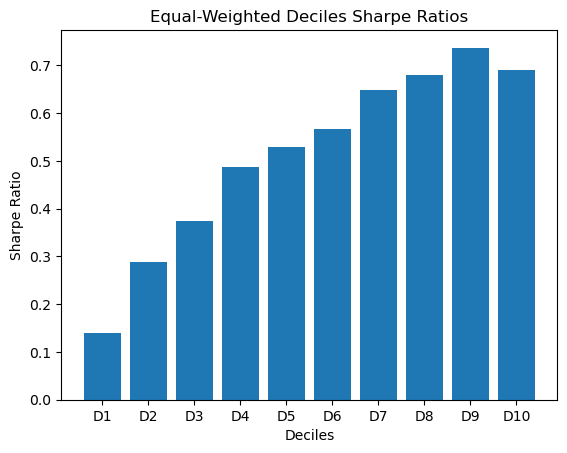

In [7]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig('vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig('ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig('vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig('ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig('vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig('ew_sharpe_ratio.png')
plt.show()

### Factor creation

### Equal-Weighted Long-Short Factor Strategy

In [16]:
# 1. Compute the long and short legs of the strategy
ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = ew_long_leg['Rn'].mean()
short_mean = ew_short_leg['Rn'].mean()

long_mean_e = ew_long_leg['excess'].mean()
short_mean_e = ew_short_leg['excess'].mean()

long_std = ew_long_leg['Rn'].std()
short_std = ew_short_leg['Rn'].std()

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = ew_long_leg - ew_short_leg
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['Rn'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.015292278003065587
Short Leg Mean Return: 0.009189389837063272
Long Leg Standard Deviation: 0.05702646993690192
Short Leg Standard Deviation: 0.07737054851812376
Long Leg Sharpe Ratio: 0.19427499197037537
Short Leg Sharpe Ratio: 0.0665853598533437
Factor Mean Return: 0.006102888166002317
Factor Standard Deviation: 0.04837948318809212
Factor Sharpe Ratio: 0.036645221957664544


In [17]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 3.356532184410281
P-Value: 0.0003946326709522996
The factor strategy has an average return that is statistically significantly different from zero.


### Value-Weighted Long-Short Factor Strategy

In [22]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['MOM_ret_vw'].mean()
short_mean = vw_short_leg['MOM_ret_vw'].mean()

long_mean_e = vw_long_leg['excess'].mean()
short_mean_e = vw_short_leg['excess'].mean()

long_std = vw_long_leg['MOM_ret_vw'].std()
short_std = vw_short_leg['MOM_ret_vw'].std()

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg - vw_short_leg
factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

factor_mean = factor['MOM_ret_vw'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['MOM_ret_vw'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.05283409486783317
Short Leg Mean Return: 0.04711340038646439
Long Leg Standard Deviation: 0.15020407378870654
Short Leg Standard Deviation: 0.21633899428915446
Long Leg Sharpe Ratio: 0.3244119059505185
Short Leg Sharpe Ratio: 0.19605733057547192
Factor Mean Return: 0.005720694481368787
Factor Standard Deviation: 0.1742614422091732
Factor Sharpe Ratio: 0.012389142646285316


In [23]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 0.8735023533368411
P-Value: 0.19119466204170554
The factor strategy does not have an average return that is statistically significantly different from zero.
